# Car Price Prediction
## Using KNN, SVM

In [1]:
## Import Common Package
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
## Import Dataset
df=pd.read_csv('carprice.csv')
## Show Data
df.head()

,ID,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
0,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
1,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
2,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
3,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
4,6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


In [3]:
## Show Missing Value
df.isna().sum()
## There are 4 columns with missing value

ID                     0
Name                   0
Location               0
Year                   0
Kilometers_Driven      0
Fuel_Type              0
Transmission           0
Owner_Type             0
Mileage_kmpl           2
Engine_CC             36
Power_bhp            142
Seats                 42
Price                  0
dtype: int64

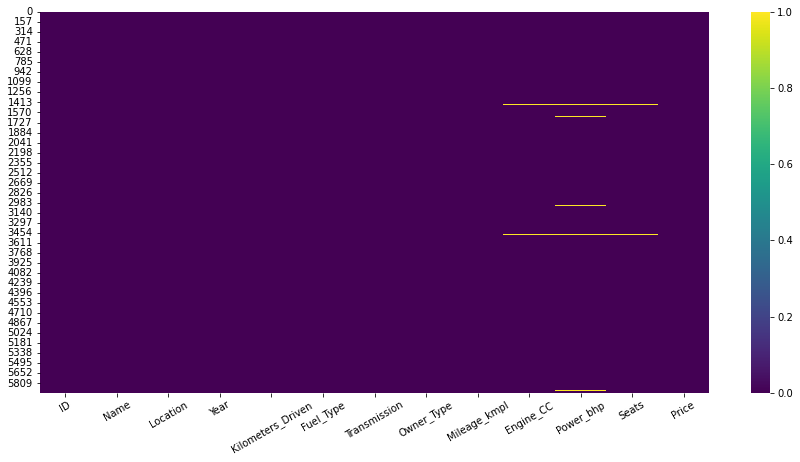

In [4]:
## Visualize Missing Value Using Heatmap
plt.figure(figsize=(15,7))
sns.heatmap(df.isna(), cmap='viridis')
plt.xticks(rotation=30)
plt.show()
## Result: missing value detected in columns mileage - seats

In [5]:
## Build For Loop to contain data for checking column details
car_priceDesc=[]

for i in df.columns:
    car_priceDesc.append([
        i,
        df[i].dtypes,
        df[i].isna().sum(),
        round((df[i].isna().sum() / len(df))*100, 2),
        df[i].nunique(),
        df[i].drop_duplicates().sample(2).values
        ])

In [6]:
## Input data into DataFrame and show details of every column
pd.DataFrame(data=car_priceDesc,
            columns=[
                'Features',
                'DataType',
                'Null',
                'Null%',
                'Unique',
                'Sample'
            ])

,Features,DataType,Null,Null%,Unique,Sample
0,ID,int64,0,0.00,5953,"[2629, 277]"
1,Name,object,0,0.00,1849,"[Fiat Grande Punto 1.4 Emotion, Hyundai Creta ..."
2,Location,object,0,0.00,11,"[Mumbai, Hyderabad]"
3,Year,int64,0,0.00,22,"[2014, 2001]"
4,Kilometers_Driven,int64,0,0.00,3062,"[52400, 41641]"
5,Fuel_Type,object,0,0.00,3,"[Diesel, Petrol]"
6,Transmission,object,0,0.00,2,"[Automatic, Manual]"
7,Owner_Type,object,0,0.00,4,"[First, Second]"
8,Mileage_kmpl,float64,2,0.03,418,"[17.01, 16.47]"
9,Engine_CC,float64,36,0.60,146,"[4806.0, 2993.0]"


### Handling Missing Value

In [7]:
## There should be no car without seats, therefore we fill in with mode
df['Seats'] = df['Seats'].fillna(df['Seats'].mode())

## For the rest, fill in with mean since there should be no car without mileage, engine size and horse power info
df=df.fillna(df.mean())

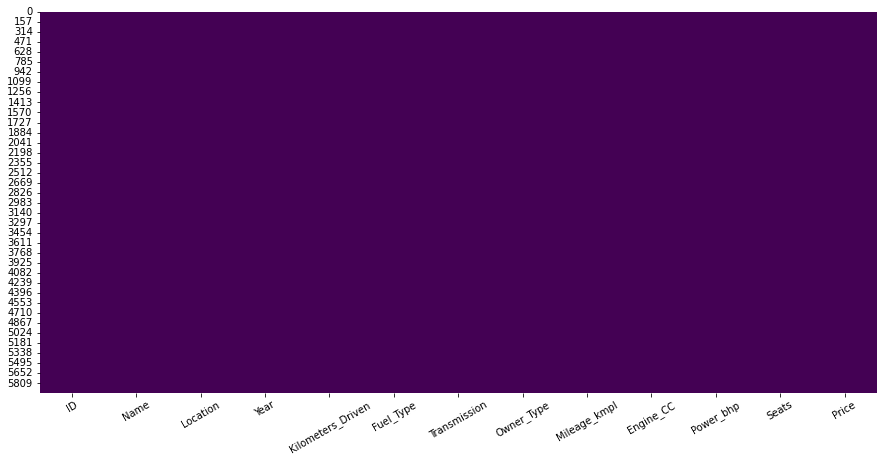

In [8]:
## Confirm Missing Value Handling Using Heatmap
plt.figure(figsize=(15,7))
sns.heatmap(df.isna(), cmap='viridis', cbar=False)
plt.xticks(rotation=30)
plt.show()
## Result: no missing value left

In [9]:
df_1=df.drop(columns=['ID','Name'])

### Re-Categorize and Encode Features

In [10]:
## 1. Check average car price in every city
pd.crosstab(df['Location'], columns='Avg Price', values=df['Price'], aggfunc='mean').round(2).sort_values('Avg Price', ascending=False)

col_0,Avg Price
Location,
Coimbatore,15.08
Bangalore,13.33
Kochi,11.26
Hyderabad,9.86
Delhi,9.83
Mumbai,9.56
Ahmedabad,8.53
Chennai,7.77
Pune,6.82


In [11]:
# Re-Categorize Location
## Build Function
def rec_loc(x):
    if (x == 'Coimbatore') or (x == 'Bangalore'):
        return x
    else:
        return 'Others'

## Add into Dataset as New Column
df_1['Location'] = df_1['Location'].apply(rec_loc)

In [12]:
## 2. Encode Transmission (Binary Encoding)
df_1['Transmission']=df_1['Transmission'].map({'Manual':0,
                                                'Automatic':1})

In [13]:
## 3. Encode Owner Type (Ordinal) Using Re-Categorize
df_1['Owner_Type'] = df_1['Owner_Type'].map({'First':0,
                                                'Second':1,
                                                'Third':2,
                                                'Fourth & Above':3
                                                })

In [14]:
## 4. Encode Fuel Type and Location Using One-Hot Encoding
df_1 = pd.get_dummies(df_1, columns=['Location','Fuel_Type'])

In [15]:
## Show Data
df_1.head()

,Year,Kilometers_Driven,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price,Location_Bangalore,Location_Coimbatore,Location_Others,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Petrol
0,2015,41000,0,0,19.67,1582.0,126.20,5.0,12.50,0,0,1,1,0,0
1,2011,46000,0,0,18.20,1199.0,88.70,5.0,4.50,0,0,1,0,0,1
2,2012,87000,0,0,20.77,1248.0,88.76,7.0,6.00,0,0,1,1,0,0
3,2013,40670,1,1,15.20,1968.0,140.80,5.0,17.74,0,1,0,1,0,0
4,2013,86999,0,0,23.08,1461.0,63.10,5.0,3.50,0,0,1,1,0,0


<hr>

## 2. Machine Learning Modelling

### Splitting Data

In [16]:
## Import Package
from sklearn.model_selection import train_test_split

In [17]:
## Define features and target
x = df_1.drop(columns='Price')
y = df_1['Price']

In [18]:
## Split Data
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.80, random_state=42)

In [19]:
## Define Features Shape
print(x_train.shape, x_test.shape)

(4762, 14) (1191, 14)


In [20]:
## Show Training Features
x_train.head()

,Year,Kilometers_Driven,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Location_Bangalore,Location_Coimbatore,Location_Others,Fuel_Type_Diesel,Fuel_Type_Electric,Fuel_Type_Petrol
4329,2016,60913,0,0,20.73,1373.0,91.100000,5.0,0,1,0,0,0,1
2644,2017,40459,0,0,19.67,1582.0,126.200000,5.0,0,0,1,1,0,0
642,2004,200000,0,0,0.00,1086.0,113.803144,5.0,0,0,1,0,0,1
5901,2018,1048,0,0,18.90,998.0,67.100000,5.0,0,0,1,0,0,1
2177,2013,96000,0,1,23.50,1498.0,90.000000,5.0,0,0,1,1,0,0


### Base Model Benchmarking using CrossValidation

In [21]:
## Import package
from sklearn.model_selection import KFold, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [22]:
## Create function to print mean of Cross-Validation score
def Cross_Val(model,x,y,Nama):
    kf = KFold(n_splits=5)
    cv_r2 = cross_val_score(model, x, y, cv = kf, scoring='r2')
    cv_MAE = cross_val_score(model, x, y, cv = kf, scoring='neg_mean_absolute_error')
    cv_MSE = cross_val_score(model, x, y, cv = kf, scoring='neg_mean_squared_error')
    cv_RMSE = cross_val_score(model, x, y, cv = kf, scoring='neg_root_mean_squared_error')
    data={
        Nama + ' Cross-Validation (Mean)':[cv_r2.mean(),cv_MAE.mean(),cv_MSE.mean(),cv_RMSE.mean()],
        Nama + ' Cross-Validation (Standard Deviation)':[cv_r2.std(),cv_MAE.std(),cv_MSE.std(),cv_RMSE.std()]
    }
    ## Create DataFrame
    df = pd.DataFrame(data,index=['R-Squared','MAE','MSE','RMSE']).T

    return df

### Training

In [23]:
## Show Cross-Validation score for KNN Model (training)
cv_KNN_tr=Cross_Val(KNeighborsRegressor(),x_train,y_train,'KNN Model Training').round(2)
cv_KNN_tr

,R-Squared,MAE,MSE,RMSE
KNN Model Training Cross-Validation (Mean),0.55,-4.15,-55.75,-7.43
KNN Model Training Cross-Validation (Standard Deviation),0.03,0.24,10.61,0.72


In [24]:
## Show Cross-Validation score for SVR Model (training)
cv_SVR_tr=Cross_Val(SVR(),x_train,y_train,'SVR Model Training').round(2)
cv_SVR_tr

,R-Squared,MAE,MSE,RMSE
SVR Model Training Cross-Validation (Mean),-0.08,-5.93,-132.45,-11.48
SVR Model Training Cross-Validation (Standard Deviation),0.02,0.36,19.13,0.85


### Testing

In [25]:
## Show Cross-Validation score for KNN Model (testing)
cv_KNN_ts=Cross_Val(KNeighborsRegressor(),x_train,y_train,'KNN Model Testing').round(2)
cv_KNN_ts

,R-Squared,MAE,MSE,RMSE
KNN Model Testing Cross-Validation (Mean),0.55,-4.15,-55.75,-7.43
KNN Model Testing Cross-Validation (Standard Deviation),0.03,0.24,10.61,0.72


In [26]:
## Show Cross-Validation score for SVR Model (testing)
cv_SVR_ts=Cross_Val(SVR(),x_train,y_train,'SVR Model Testing').round(2)
cv_SVR_ts

,R-Squared,MAE,MSE,RMSE
SVR Model Testing Cross-Validation (Mean),-0.08,-5.93,-132.45,-11.48
SVR Model Testing Cross-Validation (Standard Deviation),0.02,0.36,19.13,0.85


In [27]:
## Combine
pd.concat((cv_KNN_tr,cv_KNN_ts, cv_SVR_tr, cv_SVR_ts))

,R-Squared,MAE,MSE,RMSE
KNN Model Training Cross-Validation (Mean),0.55,-4.15,-55.75,-7.43
KNN Model Training Cross-Validation (Standard Deviation),0.03,0.24,10.61,0.72
KNN Model Testing Cross-Validation (Mean),0.55,-4.15,-55.75,-7.43
KNN Model Testing Cross-Validation (Standard Deviation),0.03,0.24,10.61,0.72
SVR Model Training Cross-Validation (Mean),-0.08,-5.93,-132.45,-11.48
SVR Model Training Cross-Validation (Standard Deviation),0.02,0.36,19.13,0.85
SVR Model Testing Cross-Validation (Mean),-0.08,-5.93,-132.45,-11.48
SVR Model Testing Cross-Validation (Standard Deviation),0.02,0.36,19.13,0.85


### Evaluation Matrix

In [28]:
## Build function to automatically perform Evaluation Matrix scoring
def Eva_Matrix(model,x_train, x_test, y_train, y_test, Nama):
    Model = model.fit(x_train, y_train)
    y_pred_tr = Model.predict(x_train)
    R2_train = r2_score(y_train, y_pred_tr)
    MAE_train = mean_absolute_error(y_train, y_pred_tr)
    MSE_train = mean_squared_error(y_train, y_pred_tr)
    RMSE_train = np.sqrt(MSE_train)
    y_pred_ts = Model.predict(x_test)
    R2_test = r2_score(y_test, y_pred_ts)
    MAE_test = mean_absolute_error(y_test, y_pred_ts)
    MSE_test = mean_squared_error(y_test, y_pred_ts)
    RMSE_test = np.sqrt(MSE_test)
    eva_data = {
    "Training " + Nama : [R2_train, MAE_train, MSE_train, RMSE_train],
    "Testing " + Nama : [R2_test, MAE_test, MSE_test, RMSE_test],
    }
    df = pd.DataFrame(eva_data, index=['R2', 'MAE', 'MSE', 'RMSE']).T
    
    return df

In [29]:
## Run Function for KNN
df_KNN = Eva_Matrix(KNeighborsRegressor(),
                    x_train, x_test, y_train, y_test,
                    'KNN')
df_KNN.round(2)
## Overfit

,R2,MAE,MSE,RMSE
Training KNN,0.73,3.23,33.16,5.76
Testing KNN,0.53,4.07,65.96,8.12


In [30]:
## Run Function for KNN
df_SVR = Eva_Matrix(SVR(),
                    x_train, x_test, y_train, y_test,
                    'SVR')
df_SVR.round(2)
## Underfit

,R2,MAE,MSE,RMSE
Training SVR,-0.08,5.92,132.24,11.50
Testing SVR,-0.07,5.98,149.40,12.22


<hr>

## 3. Improvement with Scaling

In [31]:
## Import Package
from sklearn.preprocessing import StandardScaler, RobustScaler

In [32]:
## Build and Fit model
sc = StandardScaler()
sc = sc.fit(x_train)

In [33]:
## Transform Model
x_train_sc = sc.transform(x_train)
x_test_sc = sc.transform(x_test)

### Evaluation Matrix

In [34]:
## Run Function for Evaluation Matrix
df_KNN_sc = Eva_Matrix(KNeighborsRegressor(), x_train_sc, x_test_sc, y_train, y_test, 'KNN with StandardScaler')
df_KNN_sc.round(2)
## Good R-Squared score

,R2,MAE,MSE,RMSE
Training KNN with StandardScaler,0.90,1.61,12.47,3.53
Testing KNN with StandardScaler,0.81,2.11,26.14,5.11


In [35]:
## Compare with before scaling
pd.concat((df_KNN, df_KNN_sc)).round(2)
## Result: R-Squared score soaring high from 0.53 to 0.81 after Scaling

,R2,MAE,MSE,RMSE
Training KNN,0.73,3.23,33.16,5.76
Testing KNN,0.53,4.07,65.96,8.12
Training KNN with StandardScaler,0.90,1.61,12.47,3.53
Testing KNN with StandardScaler,0.81,2.11,26.14,5.11


In [36]:
## Run Function for Evaluation Matrix
df_SVR_sc = Eva_Matrix(SVR(), x_train_sc, x_test_sc, y_train, y_test, 'SVR with StandardScaler')
df_SVR_sc.round(2)
## Good score but not that ideal

,R2,MAE,MSE,RMSE
Training SVR with StandardScaler,0.74,2.27,32.15,5.67
Testing SVR with StandardScaler,0.71,2.44,40.45,6.36


In [37]:
## Compare with before scaling
pd.concat((df_SVR, df_SVR_sc)).round(2)
## Result: R-Squared score also increase significantly from below 0 to 0.71 after Scaling

,R2,MAE,MSE,RMSE
Training SVR,-0.08,5.92,132.24,11.50
Testing SVR,-0.07,5.98,149.40,12.22
Training SVR with StandardScaler,0.74,2.27,32.15,5.67
Testing SVR with StandardScaler,0.71,2.44,40.45,6.36


<hr>

## 4. Hyper-Parameter Tuning

In [38]:
## Import Package
from sklearn.model_selection import GridSearchCV

In [39]:
## Build Model
kf = KFold(n_splits=5)

### KNN

In [40]:
## Define parameter for GridSearch in Dictionary Format
param_KNN={
    'n_neighbors':range(1,70,2),
    'weights':['uniform','distance'],
    'p':[1,2]
}

In [41]:
## Run GridSearch Model
KNN_GS=GridSearchCV(KNeighborsRegressor(),
                            param_KNN,
                            cv = kf,
                            n_jobs = -1,
                            verbose = 3,
                            scoring = 'r2')
## Fit Model
KNN_GS.fit(x_train_sc,y_train)

Fitting 5 folds for each of 140 candidates, totalling 700 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': range(1, 70, 2), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=3)

In [42]:
## Run Evaluation Matrix Scoring function for KNN with GridSearch and StandardScaler Model
df_KNN_GS= Eva_Matrix(KNN_GS, 
                        x_train_sc, 
                        x_test_sc, 
                        y_train, 
                        y_test, 
                        'KNN + GS + SC')
## Show result
df_KNN_GS.round(4)
## Result: Training R-Squared Score show overfitting in the Model, but score is better than before tuning

Fitting 5 folds for each of 140 candidates, totalling 700 fits


,R2,MAE,MSE,RMSE
Training KNN + GS + SC,0.9999,0.0055,0.0082,0.0908
Testing KNN + GS + SC,0.8451,1.8507,21.7031,4.6587


In [43]:
## Best Tuning Score and Parameter
print('Best KNN GridSearch + StandardScaler Tuning Score: ', KNN_GS.best_score_.round(4))
print('Best KNN GridSearch + StandardScaler Tuning Parameter: ', KNN_GS.best_params_)

Best KNN GridSearch + StandardScaler Tuning Score:  0.851
Best KNN GridSearch + StandardScaler Tuning Parameter:  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


In [44]:
## Insert Best Parameter into Model
KNN_Tuned=KNN_GS.best_estimator_

In [45]:
## Run Evaluation Matrix Scoring function for tuned Model
df_KNN_Tuned= Eva_Matrix(KNN_Tuned, 
                        x_train_sc, 
                        x_test_sc, 
                        y_train, 
                        y_test, 
                        'KNN Tuned')
## Show result
df_KNN_Tuned.round(4)
## Result: Training R-Squared Score show overfitting in the Model, but better than before Tuning

,R2,MAE,MSE,RMSE
Training KNN Tuned,0.9999,0.0055,0.0082,0.0908
Testing KNN Tuned,0.8451,1.8507,21.7031,4.6587


In [63]:
## Combine with Model before GridSearch
pd.concat((df_KNN, df_KNN_sc, df_KNN_Tuned)).round(4)
## Testing score has scored higher than previous Model before using GridSearch
### However, the Model is more overfit than previous one.
### Therefore, we choose to use KNN + StandardScaler without GridSearch because Model show more stability
### In addition, the R-Squared score is good enough to be consider as an ideal Model.

,R2,MAE,MSE,RMSE
Training KNN,0.7295,3.2261,33.1573,5.7582
Testing KNN,0.5294,4.0726,65.9582,8.1215
Training KNN with StandardScaler,0.8983,1.6099,12.4703,3.5313
Testing KNN with StandardScaler,0.8135,2.1086,26.1363,5.1124
Training KNN Tuned,0.9999,0.0055,0.0082,0.0908
Testing KNN Tuned,0.8451,1.8507,21.7031,4.6587


### SVR

In [52]:
## Define parameter for GridSearch in Dictionary Format
param_SVR={
    'C' : np.arange(0, 5, 0.1),
    'gamma': np.arange(0, 5, 0.1),
    # 'kernel' : ['rbf','linear']
}

In [53]:
## Run GridSearch Model
SVR_GS=GridSearchCV(SVR(max_iter = 300),
                    param_SVR,
                    cv = KFold(n_splits=3),
                    n_jobs = -1,
                    verbose = 1,
                    scoring = 'r2')
## Fit Model
SVR_GS.fit(x_train_sc,y_train)

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


GridSearchCV(cv=KFold(n_splits=3, random_state=None, shuffle=False),
             estimator=SVR(max_iter=300), n_jobs=-1,
             param_grid={'C': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9]),
                         'gamma': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9])},
             scoring='r2', verbose=1)

In [54]:
## Run Evaluation Matrix Scoring function for SVR with GridSearch and StandardScaler Model
df_SVR_GS= Eva_Matrix(SVR_GS, 
                        x_train_sc, 
                        x_test_sc, 
                        y_train, 
                        y_test, 
                        'SVR + GS + SC')
## Show result
df_SVR_GS.round(4)
## Result: Model is stable but score is not ideal

Fitting 3 folds for each of 2500 candidates, totalling 7500 fits


,R2,MAE,MSE,RMSE
Training SVR + GS + SC,0.6970,3.6337,37.1379,6.0941
Testing SVR + GS + SC,0.6655,3.8670,46.8807,6.8469


In [57]:
## Best Tuning Score and Parameter
print('Best SVR GridSearch + StandardScaler Tuning Score: ', SVR_GS.best_score_.round(4))
print('Best SVR GridSearch + StandardScaler Tuning Parameter: ', SVR_GS.best_params_)

Best SVR GridSearch + StandardScaler Tuning Score:  0.7307
Best SVR GridSearch + StandardScaler Tuning Parameter:  {'C': 3.9000000000000004, 'gamma': 0.1}


In [58]:
## Insert Best Parameter into Model
SVR_Tuned = SVR_GS.best_estimator_

In [59]:
## Run Evaluation Matrix Scoring function for tuned Model
df_SVR_Tuned = Eva_Matrix(SVR_Tuned, 
                            x_train_sc, 
                            x_test_sc, 
                            y_train, 
                            y_test, 
                            'SVR Tuned')
## Show result
df_SVR_Tuned.round(4)
## Result: Model is stable but score is not ideal

,R2,MAE,MSE,RMSE
Training SVR Tuned,0.6970,3.6337,37.1379,6.0941
Testing SVR Tuned,0.6655,3.8670,46.8807,6.8469


In [64]:
## Combine with Model before GridSearch
pd.concat((df_SVR, df_SVR_sc, df_SVR_Tuned)).round(4)
## Testing score has scored ;pwer than previous Model before using GridSearch
### Overall, the Model is stable, but can not produce higher score to reach 0.80

,R2,MAE,MSE,RMSE
Training SVR,-0.0788,5.9159,132.2378,11.4995
Testing SVR,-0.0660,5.9829,149.3998,12.2229
Training SVR with StandardScaler,0.7377,2.2661,32.1503,5.6701
Testing SVR with StandardScaler,0.7114,2.4413,40.4491,6.3600
Training SVR Tuned,0.6970,3.6337,37.1379,6.0941
Testing SVR Tuned,0.6655,3.8670,46.8807,6.8469


<hr>

## 5. Summary

Our best Model is using base KNN algorithm with StandardScaler.

In [62]:
## Show Evaluation Matrix of Best Model
df_KNN_sc

,R2,MAE,MSE,RMSE
Training KNN with StandardScaler,0.898268,1.609863,12.470291,3.531330
Testing KNN with StandardScaler,0.813515,2.108593,26.136335,5.112371
